In [38]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [39]:
jax.config.update('jax_platform_name', 'cpu')


In [40]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [41]:
import numpyro
import numpyro.distributions as dist

# Eight Schools example
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)


In [4]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))


sample: 100%|█| 1500/1500 [00:31<00:00, 48.17it/s, 63 steps of size 4.53e-02. ac


In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.57      3.53      4.36     -1.72      9.51    138.24      1.01
       tau      3.60      3.06      2.87      0.25      7.62     91.97      1.01
  theta[0]      6.24      5.64      5.67     -3.22     13.91    204.27      1.00
  theta[1]      5.05      4.81      4.76     -2.75     12.11    236.71      1.00
  theta[2]      4.14      5.24      4.10     -4.40     12.23    263.75      1.01
  theta[3]      4.91      5.01      4.76     -3.90     12.01    247.83      1.00
  theta[4]      3.74      5.19      3.78     -4.60     11.93    210.18      1.01
  theta[5]      4.17      4.83      4.16     -3.79     12.05    214.35      1.01
  theta[6]      6.62      5.07      6.33     -1.41     14.35    179.37      1.00
  theta[7]      5.01      5.22      4.64     -3.74     12.53    239.29      1.00

Number of divergences: 2


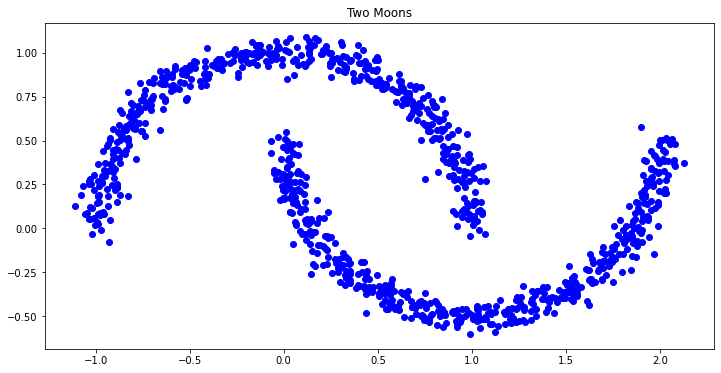

In [12]:
# Data - Two Moons
n = 1000
X = make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:, 1], c="b")
plt.title("Two Moons")
plt.show()

In [42]:
from jax.example_libraries import stax
from numpyro.distributions.transforms import Transform, constraints

In [48]:
class Planar(Transform):

    domain = constraints.real_vector
    codomain = constraints.real_vector

    def __init__(
        self, b, u, w
    ):
        """
        :param autoregressive_nn: an autoregressive neural network whose forward call returns a real-valued
            mean and log scale as a tuple
        """
        self.bias = b
        self.u = u
        self.w = w
    
    def u_hat(self, u, w):
        print(u.shape)
        alpha = jnp.matmul(u.unsqueeze(-2), w.unsqueeze(-1)).squeeze(-1)
        a_prime = -1 + jax.nn.softplus(alpha)
        return u + (a_prime - alpha) * w.div(w.pow(2).sum(axis=-1, keepdim=True))

#     def __call__(self, x):
#         """
#         :param numpy.ndarray x: the input into the transform
#         """
#         return self.call_with_intermediates(x)[0]

#     def call_with_intermediates(self, x):
#         mean, log_scale = self.arn(x)
#         log_scale = _clamp_preserve_gradients(
#             log_scale, self.log_scale_min_clip, self.log_scale_max_clip
#         )
#         scale = jnp.exp(log_scale)
#         return scale * x + mean, log_scale


#     def _inverse(self, y):
#         """
#         :param numpy.ndarray y: the output of the transform to be inverted
#         """
#         # NOTE: Inversion is an expensive operation that scales in the dimension of the input
#         def _update_x(i, x):
#             mean, log_scale = self.arn(x)
#             inverse_scale = jnp.exp(
#                 -_clamp_preserve_gradients(
#                     log_scale, min=self.log_scale_min_clip, max=self.log_scale_max_clip
#                 )
#             )
#             x = (y - mean) * inverse_scale
#             return x

#         x = fori_loop(0, y.shape[-1], _update_x, jnp.zeros(y.shape))
#         return x

#     def log_abs_det_jacobian(self, x, y, intermediates=None):
#         """
#         Calculates the elementwise determinant of the log jacobian.

#         :param numpy.ndarray x: the input to the transform
#         :param numpy.ndarray y: the output of the transform
#         """
#         if intermediates is None:
#             log_scale = self.arn(x)[1]
#             log_scale = _clamp_preserve_gradients(
#                 log_scale, self.log_scale_min_clip, self.log_scale_max_clip
#             )
#             return log_scale.sum(-1)
#         else:
#             log_scale = intermediates
#             return log_scale.sum(-1)


In [49]:
from jax import random

In [50]:
key=random.PRNGKey(42)

In [51]:
planar = Planar(random.normal(key, [1]), random.normal(key, [4]), random.normal(key, [4]))





In [52]:
planar.u_hat(planar.u, planar.w)

(4,)


AttributeError: 'DeviceArray' object has no attribute 'unsqueeze'

In [13]:
class NormalizingFlow:
    
    def model(self, X=None):
        N = len(X) if X is None else None
        numpyro.module("nf", )